<a href="https://colab.research.google.com/github/zhuhanzhi6/Hanzhi-Zhu-machine-learning/blob/main/Copy_of_Lecture7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a Model from Scratch

<div style="background-color: #f8d7da; border-left: 6px solid #ccc; margin: 20px; padding: 15px;">
    <strong>💡 Mildred Dresselhaus:</strong> People said you’re crazy... But if you think you’re right, stick to it. And we were right.
</div>

<iframe class="speakerdeck-iframe" frameborder="0" src="https://speakerdeck.com/player/31699a6d5e6c47f1be25e6dd16af566b" title="Machine Learning for Materials (Lecture 7)" allowfullscreen="true" style="border: 0px; background-clip: padding-box; background-color: rgba(0, 0, 0, 0.1); margin: 0px; padding: 0px; border-radius: 6px; box-shadow: rgba(0, 0, 0, 0.2) 0px 5px 40px; width: 50%; height: auto; aspect-ratio: 560 / 420;" data-ratio="1.3333333333333333"></iframe>

[Lecture slides](https://speakerdeck.com/aronwalsh/mlformaterials-lecture7-build)

## 🦾 Crystal hardness revisited

We first tackled the [bulk modulus](https://en.wikipedia.org/wiki/Bulk_modulus) of inorganic crystals in Lecture 2. However our model development was not thorough back then.

Let's revisit this problem using the new knowledge and tricks we have picked up. We will follow the same initial steps, making use of [matminer](https://matminer.readthedocs.io) to access the materials dataset and featurise the data.

In [ ]:
# Installation of libraries
!pip install matminer==0.9.3 --quiet
!pip install xgboost==3.1.2 --quiet

In [ ]:
# Downgrade scikit to avoid a conflict with xgboost
#!pip uninstall -y scikit-learn --quiet
#!pip install scikit-learn==1.3.1 --quiet

In [ ]:
# Import of modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pprint
import seaborn as sns
plt.style.use('ggplot')

# Advanced
from pymatgen.core import Structure
import matminer
from matminer.datasets.dataset_retrieval import load_dataset
from monty.serialization import loadfn

# To make the model run faster
teaching_mode = True

<details>
<summary>Colab error solution</summary>
If running the import module cell fails with an "AttributeError", click `Runtime` -> `Restart Session` and then simply rerun the cell.
</details>

## Data preparation

The steps to load and featurise the bulk modulus data were introduced in Notebook 2, so we can jump straight in.

In [ ]:
# Use matminer to load the dataset
df = load_dataset('matbench_log_kvrh')
print(f'The full dataset contains {df.shape[0]} entries. \n')

if teaching_mode:
  # Store the original DataFrame as a copy
  full_dataset_df = df.copy()
  # Create a subset of the original DataFrame for demonstration purposes
  df = df.sample(n=1000, random_state=33)
  print(f'For teaching purposes we will only work with {df.shape[0]} entries from the dataframe to make the model training and testing faster. \n')

print('The DataFrame is shown below:')
df.head(10)

The full dataset contains 10987 entries. 

For teaching purposes we will only work with 1000 entries from the dataframe to make the model training and testing faster. 

The DataFrame is shown below:


,structure,log10(K_VRH)
8056,"[[2.06897294 2.07140866 2.07140866] Rb, [0. 0....",1.806180
5435,"[[ 1.70008832 2.25388785 -1.56177691] O, [1.1...",1.255273
683,"[[1.95293774 1.38093552 3.38258738] O, [0. 0. ...",2.100371
292,"[[0. 0. 0.] N, [2.39230692 1.38119902 2.204841...",2.454845
8896,"[[0. 0. 0.] N, [-1.47701996e-08 1.70551574e+0...",2.528917
7903,"[[0. 0. 0.] Na, [3.03138537 3.03138537 3.03138...",1.113943
2774,"[[2.63855017 3.11606198 6.90394601] O, [3.0438...",1.591065
1707,"[[ 5.88340266 3.08816028 -2.12851027] Li, [ 2...",2.017033
10860,"[[4.5300617 1.49127167 7.84629702] O, [2.9160...",1.662758
9022,"[[3.51673412 0. 1.28204684] Si, [1.172...",2.426511


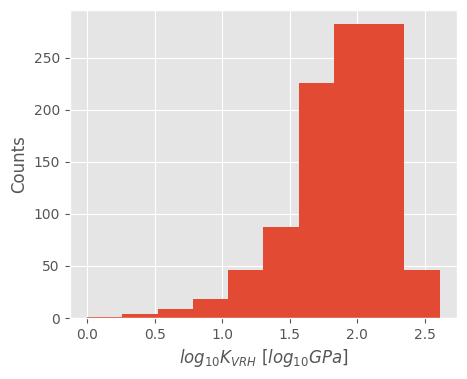

In [ ]:
# Plot a histogram of values
fig, ax = plt.subplots(figsize=(5, 4))
ax.hist(df['log10(K_VRH)'])
ax.set_xlabel(r'$log_{10}K_{VRH}$ [$log_{10}GPa$]' )
ax.set_ylabel('Counts')
plt.show()

In [ ]:
# Use matminer to featurise the dataset
from matminer.featurizers.composition.composite import ElementProperty
from matminer.featurizers.structure.order import DensityFeatures

# Add a composition column to df using the composition property of the Structure class
df['composition'] = df.structure.apply(lambda x: x.composition )

# Create the ElementProperty featuriser
el_prop_featuriser = ElementProperty.from_preset(preset_name='magpie')

# By default multiprocessing is enabled, however, this can slow performance, so we disable it
el_prop_featuriser.set_n_jobs(1)

# Create the DensityFeatures featuriser
density_featuriser = DensityFeatures()
density_featuriser.set_n_jobs(1)

# Get all possible feature labels from both featurizers
all_feature_labels = el_prop_featuriser.feature_labels() + density_featuriser.feature_labels()

# Drop any existing feature columns from df before starting featurization
# This handles cases where the dataframe might have been partially featurized in a previous run
# and ensures a clean state for featurization.
columns_to_drop = [col for col in df.columns if col in all_feature_labels]
if columns_to_drop:
    df.drop(columns=columns_to_drop, inplace=True)

# Create a copy of the DataFrame for featurization to avoid conflicts on re-runs
df_featurized = df.copy()

# Featurise using the ElementProperty featuriser
df_featurized = el_prop_featuriser.featurize_dataframe(df_featurized, col_id='composition')

# Add structure features to the featurized DataFrame
df_featurized = density_featuriser.fit_featurize_dataframe(df_featurized, col_id='structure')

# Update the main df variable with the fully featurized DataFrame
df = df_featurized

# Print the shape of the DataFrame
print(df.shape)
df.head()

/usr/local/lib/python3.12/dist-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


ElementProperty:   0%|          | 0/1000 [00:00<?, ?it/s]

DensityFeatures:   0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 138)


,structure,log10(K_VRH),composition,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,...,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,density,vpa,packing fraction
8056,"[[2.06897294 2.07140866 2.07140866] Rb, [0. 0....",1.806180,"(Rb, Cu, F)",9.0,37.0,28.0,18.600000,11.520000,9.0,4.0,...,0.0,15.0,229.0,214.0,99.800000,101.760000,15.0,4.816804,14.203859,0.932682
5435,"[[ 1.70008832 2.25388785 -1.56177691] O, [1.1...",1.255273,"(O, Cs)",8.0,55.0,47.0,23.666667,20.888889,8.0,5.0,...,0.0,12.0,229.0,217.0,84.333333,96.444444,12.0,3.732206,24.456488,1.028108
683,"[[1.95293774 1.38093552 3.38258738] O, [0. 0. ...",2.100371,"(O, Cd)",8.0,48.0,40.0,28.000000,20.000000,8.0,70.0,...,0.0,12.0,194.0,182.0,103.000000,91.000000,12.0,7.791431,13.683654,0.603030
292,"[[0. 0. 0.] N, [2.39230692 1.38119902 2.204841...",2.454845,"(N, Cr)",7.0,24.0,17.0,18.333333,7.555556,24.0,49.0,...,0.0,194.0,229.0,35.0,217.333333,15.555556,229.0,6.723826,9.713804,0.828320
8896,"[[0. 0. 0.] N, [-1.47701996e-08 1.70551574e+0...",2.528917,"(N, Ta)",7.0,73.0,66.0,40.000000,33.000000,7.0,48.0,...,0.0,194.0,229.0,35.0,211.500000,17.500000,194.0,14.763854,10.963590,0.634847


Let's understand the feature space a little better.

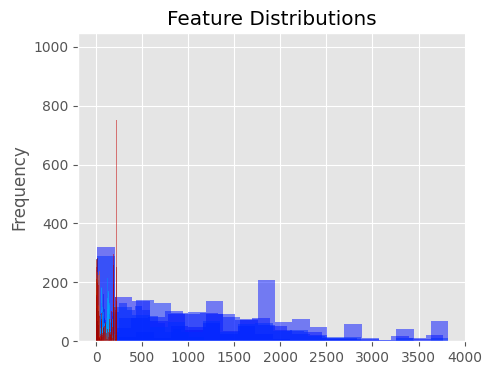

In [ ]:
# Extract the feature columns (excluding the first three)
feature_columns = df.columns[3:]

# Create a unique colour for each feature
colors = [plt.cm.jet(i / float(len(feature_columns))) for i in range(len(feature_columns))]

# Plot the distribution of feature values with different colours
plt.figure(figsize=(5, 4))
for i, column in enumerate(feature_columns):
    df[column].plot(kind='hist', bins=20, alpha=0.5, color=colors[i], label=column)

plt.title('Feature Distributions')
plt.show()

<details>
<summary> Code hint </summary>
Add some bins to your histogram. 10-20 should be sufficient.
</details>

Some dimensions have very different ranges, as you can see from the spread on the x-axis. We can standardise these features to make them more comparable. This is a common practice in machine learning, especially when using algorithms sensitive to feature magnitudes.

`MinMaxScaler` is a data scaling technique to transform numerical features within the range [0, 1]. It linearly scales data, preserving relationships between values, making it suitable for algorithms sensitive to feature magnitudes.

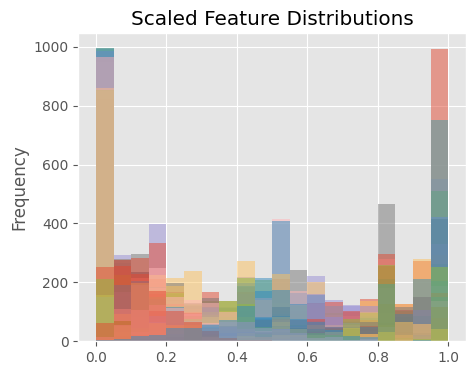

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaled_df = df.copy()

# Step 1: Scale the feature columns
scaler = MinMaxScaler()
scaled_df[feature_columns] = scaler.fit_transform(scaled_df[feature_columns])

# Step 2: Plot the scaled feature distributions
plt.figure(figsize=(5, 4))
for column in feature_columns:
    scaled_df[column].plot(kind='hist', bins=20, alpha=0.5, label=column)

plt.title('Scaled Feature Distributions')
plt.show()

Finally, let's prepare the data for model training. We need to split the dataset into the target variable `log10(K_VRH)` and the input features. For the input features, we must remove any non-numerical data to avoid getting errors later in our workflow.

In [ ]:
# Define the features we want
features_to_drop = ['structure','composition','log10(K_VRH)']
feature_cols = [col for col in list(df.columns) if col not in features_to_drop]

# Get an array of the features
X = df[feature_cols].values
scaled_X = scaled_df[feature_cols].values

# Get an array of the target variable
y = df['log10(K_VRH)'].values

print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')

Shape of X: (1000, 135)
Shape of y: (1000,)


## Model choice


We are dealing with a supervised regression problem, so should choose a suitable machine learning model. We can start by rebuilding a random forest. Are you curious if the feature scaling has an effect? I am.

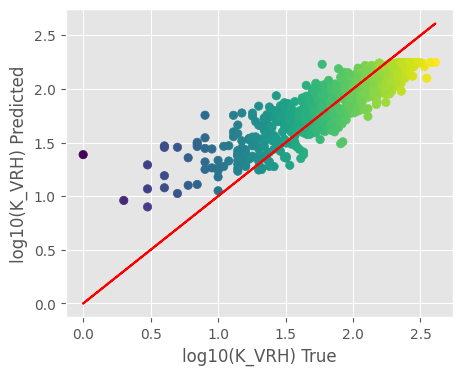

The training MAE = 0.136 log10GPa
The training RMSE = 0.187 log10GPa
The training r^2 = 0.742


In [ ]:
# Random forest - original features
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

# Define the model
rf = RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=3, min_samples_split=2, min_samples_leaf=1, random_state=42)

# Fit the model
rf.fit(X, y)

# Wrap the lines of code for later sections
def make_prediction_plot(X, y, model, label):
    y_pred = model.predict(X)  # Calculate predictions here
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.scatter(y, y_pred, c=y, cmap='viridis')
    ax.plot(y, y, 'r-')
    ax.set_xlabel(f'{label} True')
    ax.set_ylabel(f'{label} Predicted')
    plt.show()
    return y_pred  # Return y_pred

# Performance
y_pred = make_prediction_plot(X, y, rf, 'log10(K_VRH)')

print(f'The training MAE = {metrics.mean_absolute_error(y,y_pred):.3f} log10GPa')
print(f'The training RMSE = {np.sqrt(metrics.mean_squared_error(y,y_pred)):.3f} log10GPa')
print(f'The training r^2 = {rf.score(X,y):.3f}')

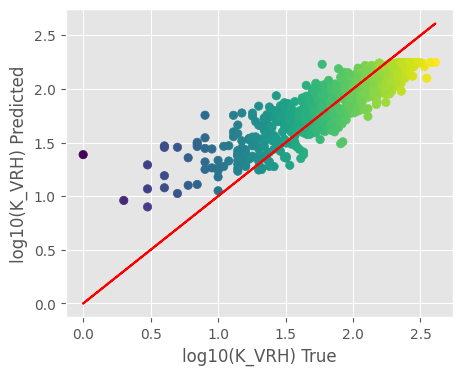

The training MAE = 0.136 log10GPa
The training RMSE = 0.187 log10GPa
The training r^2 = 0.742


In [ ]:
# Random forest - scaled features

# Define the model
rf2 = RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=3, min_samples_split=2, min_samples_leaf=1, random_state=42)

# Fit the model
rf2.fit(scaled_X, y)

# Performance
y_pred = make_prediction_plot(scaled_X, y, rf2, 'log10(K_VRH)')
print(f'The training MAE = {metrics.mean_absolute_error(y, y_pred):.3f} log10GPa')
print(f'The training RMSE = {np.sqrt(metrics.mean_squared_error(y, y_pred)):.3f} log10GPa')
print(f'The training r^2 = {rf2.score(scaled_X, y):.3f}')

We can see that Random Forest is not sensitive to feature scaling. Recall that this model works by averaging over multiple decision trees, and the decision boundaries are determined by feature thresholds, not their absolute values.

We have time to try one more model. Let's go with the popular [XGBoost](https://xgboost.readthedocs.io). Like Random Forest, it is an ensemble learning method. XGBoost uses a gradient-boosting framework and often achieves higher predictive accuracy by optimising for both bias and variance in the model.

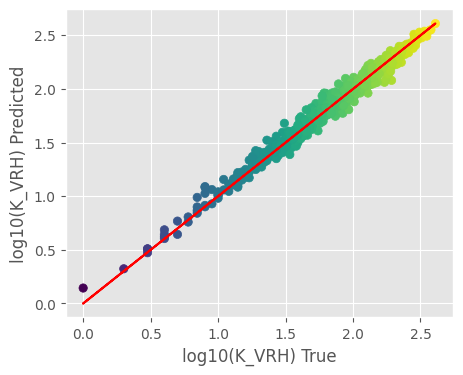

The training MAE = 0.035 log10GPa
The training RMSE = 0.048 log10GPa
The training r^2 = 0.983


In [ ]:
# XGBoost model
import xgboost as xgb

# Define the model
xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=3, random_state=42, objective='reg:squarederror')

# Fit the model
xgb_model.fit(scaled_X, y)

# Performance
y_pred = make_prediction_plot(scaled_X, y, xgb_model, 'log10(K_VRH)')
print(f'The training MAE = {metrics.mean_absolute_error(y, y_pred):.3f} log10GPa')
print(f'The training RMSE = {np.sqrt(metrics.mean_squared_error(y, y_pred)):.3f} log10GPa')
print(f'The training r^2 = {xgb_model.score(scaled_X, y):.3f}')

XGBoost does a better job, but wait...

We haven't performed proper training and testing yet 😱. These models are likely to be overfit and unable to make useful predictions for new inputs. On to the next stage!

## Training and testing

### Train-test split

We are ready to build a real model now. Let's separate the training data from the unseen test set used to assess model performance.

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42)

# Print the sizes of the arrays
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (800, 135)
y_train shape: (800,)
X_test shape: (200, 135)
y_test shape: (200,)


<details>
<summary> Code hint </summary>
The library is "sklearn"!
</details>

### Cross-validation

Using the 80% training set, we can train a model by making use of [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html) in an attempt to avoid overfitting. Note that this step may take a minute to run as 10 models are being trained (i.e. 5-fold cross-validation x 2 models).

<details>
<summary> Recap of cross-validation </summary>
Cross-validation partitions data into multiple subsets, training the model on some and validating it on others, ensuring robust evaluation.

_Key types include:_

- **k-Fold Cross-Validation**: Data is split into *k* folds; each fold is used as a validation set once while training on the remaining *k-1* folds.
- **Leave-One-Out Cross-Validation (LOOCV)**: Each data point is used as a validation set once, with the rest for training.
- **Stratified k-Fold**: Preserves class proportions in each fold, useful for imbalanced datasets.
- **Time Series Cross-Validation**: Ensures training always precedes validation, preserving temporal structure.

_Typical workflow:_

1. **Split Data**: Divide the dataset into *k* folds.
2. **Train and Validate**: Train the model on *k-1* folds, validate on the remaining fold.
3. **Repeat**: Cycle through all folds, ensuring each serves as a validation set.
4. **Aggregate Results**: Compute performance metrics across all iterations.
5. **Train Final Model:** Fit the model using the full training dataset based on cross-validation insights.
</details>

In [ ]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

# Define models
xgb_model = XGBRegressor(n_estimators=100, max_depth=3, random_state=42, objective='reg:squarederror')
rf_model = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42)

# Perform cross-validation for XGBoost
xgb_cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
xgb_rmse = np.sqrt(-xgb_cv_scores)  # Convert to RMSE

# Perform cross-validation for Random Forest
rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rf_rmse = np.sqrt(-rf_cv_scores)  # Convert to RMSE

# Print results
# Compare the results
print("XGBoost Cross-Validation Results")
print(f"  Mean RMSE: {xgb_rmse.mean():.3f}")
print(f"  Standard Deviation of RMSE: {xgb_rmse.std():.3f}")

print("\nRandom Forest Cross-Validation Results")
print(f"  Mean RMSE: {rf_rmse.mean():.3f}")
print(f"  Standard Deviation of RMSE: {rf_rmse.std():.3f}")

XGBoost Cross-Validation Results
  Mean RMSE: 0.154
  Standard Deviation of RMSE: 0.014

Random Forest Cross-Validation Results
  Mean RMSE: 0.201
  Standard Deviation of RMSE: 0.025


<div style="background-color: #d4edda; border-left: 6px solid #ccc; margin: 20px; padding: 15px;">
    <strong>🙋 Cross-validation output:</strong><br>
    • <strong>Mean RMSE:</strong> Mean error across the cross-validation folds (smaller = better).<br>
    • <strong>Standard Deviation of RMSE:</strong> Variability in error across the folds (smaller = more consistent).<br>
</div>

### Hyperparamater optimisation

XGBoost is in the lead! So far, we have not adjusted the models themselves. It is possible to improve performance by tuning the hyperparameters. Manually tuning would be laborious. We can use `GridSearchCV` to automate the search.

Note that this step will be even more computationally expensive as we are performing cross-validation as a function of model hyperparameters for two separate models. You can see how computational cost quickly escalates and this is where powerful GPUs can become essential for machine learning!

<div style="background-color: #d4edda; border-left: 6px solid #ccc; margin: 20px; padding: 15px; border-radius: 5px;">
    <strong>⏱️ This will take 2-3 min to run. Think about how the model is learning from data.
</div>

In [ ]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.1, 0.2]
}

xgb_grid_search = GridSearchCV(XGBRegressor(random_state=42), xgb_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)

best_xgb_params = xgb_grid_search.best_params_
best_xgb_model = xgb_grid_search.best_estimator_

# Hyperparameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'min_samples_split': [2, 4]
}

rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

best_rf_params = rf_grid_search.best_params_
best_rf_model = rf_grid_search.best_estimator_

# Evaluate the best models
xgb_cv_scores = -cross_val_score(best_xgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
xgb_rmse = np.sqrt(xgb_cv_scores)

rf_cv_scores = -cross_val_score(best_rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rf_rmse = np.sqrt(rf_cv_scores)

# Compare the results of the best models
print("Best XGBoost Hyperparameters:", best_xgb_params)
print("Best XGBoost Cross-Validation Results")
print(f"  Mean RMSE: {xgb_rmse.mean():.3f}")
print(f"  Standard Deviation of RMSE: {xgb_rmse.std():.3f}")

print("\nBest Random Forest Hyperparameters:", best_rf_params)
print("Best Random Forest Cross-Validation Results")
print(f"  Mean RMSE: {rf_rmse.mean():.3f}")
print(f"  Standard Deviation of RMSE: {rf_rmse.std():.3f}")

Best XGBoost Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best XGBoost Cross-Validation Results
  Mean RMSE: 0.144
  Standard Deviation of RMSE: 0.018

Best Random Forest Hyperparameters: {'max_depth': 6, 'min_samples_split': 2, 'n_estimators': 200}
Best Random Forest Cross-Validation Results
  Mean RMSE: 0.160
  Standard Deviation of RMSE: 0.019


Was it worth the effort? There should be improvements in the RMSE for both models. Note the optimal hyperparameters found.

### Model assessment

Now that we have our best trained models, let's see how they perform on *unseen* test data. Comparing test performance to training performance will help us determine if the model generalises well or shows signs of overfitting or underfitting.

XGBoost test results:
RMSE: 0.169
R²: 0.809

Random Forest test results:
RMSE: 0.193
R²: 0.750


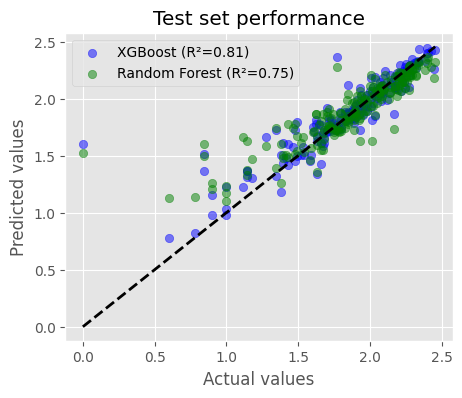

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Test the best XGBoost model
xgb_test_preds = best_xgb_model.predict(X_test)
xgb_test_rmse = np.sqrt(mean_squared_error(y_test, xgb_test_preds))
xgb_test_r2 = r2_score(y_test, xgb_test_preds)

# Test the best Random Forest model
rf_test_preds = best_rf_model.predict(X_test)
rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_test_preds))
rf_test_r2 = r2_score(y_test, rf_test_preds)

# Print test results
print("XGBoost test results:")
print(f"RMSE: {xgb_test_rmse:.3f}")
print(f"R²: {xgb_test_r2:.3f}")

print("\nRandom Forest test results:")
print(f"RMSE: {rf_test_rmse:.3f}")
print(f"R²: {rf_test_r2:.3f}")

# Create a scatter plot with both models in different colors
plt.figure(figsize=(5, 4))
plt.scatter(y_test, xgb_test_preds, c='blue', label=f'XGBoost (R²={xgb_test_r2:.2f})', alpha=0.5)
plt.scatter(y_test, rf_test_preds, c='green', label=f'Random Forest (R²={rf_test_r2:.2f})', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)  # Reference line (y=x)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Test set performance")
plt.legend()
plt.show()

XGBoost outperforms Random Forest in both cross-validation and test performance for this task, with the slight increase in RMSE from train to test suggesting both models generalise reasonably well.

### Model speed

The speed of a model may also be important, e.g. a use case involving millions of predictions. Several factors can influence the computational performance, including the dataset size, model complexity, and hardware. We can perform a simple comparison of our two models using `time`.

In [ ]:
import time

# Measure the training time for XGBoost
start_time = time.time()
xgb_model.fit(X_train, y_train)
xgb_training_time = time.time() - start_time

# Measure the training time for Random Forest
start_time = time.time()
rf_model.fit(X_train, y_train)
rf_training_time = time.time() - start_time

# Measure the prediction time for XGBoost
start_time = time.time()
xgb_test_preds = xgb_model.predict(X_test)
xgb_prediction_time = time.time() - start_time

# Measure the prediction time for Random Forest
start_time = time.time()
rf_test_preds = rf_model.predict(X_test)
rf_prediction_time = time.time() - start_time

print(f"XGBoost training time: {xgb_training_time:.4f} seconds")
print(f"Random Forest training time: {rf_training_time:.4f} seconds")
print(f"\nXGBoost prediction time: {xgb_prediction_time:.4f} seconds")
print(f"Random Forest prediction time: {rf_prediction_time:.4f} seconds")

XGBoost training time: 0.2917 seconds
Random Forest training time: 1.3915 seconds

XGBoost prediction time: 0.0022 seconds
Random Forest prediction time: 0.0058 seconds


It is clear that the XGBoost library has been well optimised to run quickly.

## 🚨 Exercise 7

<div style="background-color: #dceefb; border-left: 6px solid #ccc; margin: 20px; padding: 15px; border-radius: 5px;">
    <strong>💡 Coding exercises:</strong> The exercises are designed to apply what you have learned with room for creativity. It is fine to discuss solutions with your classmates, but the actual code should not be directly copied.
</div>

### Your details

In [ ]:
import numpy as np

# Insert your values
Name = "Hanzhi Zhu" # Replace with your name
CID = 2243276 # Replace with your College ID (as a numeric value with no leading 0s)

# Set a random seed using the CID value
CID = int(CID)
np.random.seed(CID)

# Print the message
print("This is the work of " + Name + " [CID: " + str(CID) + "]")

This is the work of Hanzhi Zhu [CID: 2243276]


### 🧪 Problem: Exploring Regression Models for Crystal Hardness  

We will compare different machine learning regressors for predicting the **bulk modulus** (log10(K<sub>VRH</sub>)) of inorganic crystals.  

Tasks will be given in class.  

In [ ]:
#Task 1
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

knn = KNeighborsRegressor(n_neighbors=6)

scores = cross_val_score(
    knn, X_train, y_train,
    cv=5,
    scoring="neg_mean_squared_error"
)

rmse = np.sqrt(-scores)

print("Mean CV RMSE (KNN):", rmse.mean())



Mean CV RMSE (KNN): 0.26630184274577706


In [ ]:
A k-nearest neighbour regression model was trained and evaluated using 5-fold cross-validation. The model achieved a mean cross-validation RMSE of 0.266, indicating moderate predictive performance. Compared with XGBoost on the test set (RMSE = 0.169, R² = 0.809), KNN shows inferior performance, suggesting that ensemble tree-based models are better suited for capturing the non-linear relationships in this dataset.

In [ ]:
#Task 2
from sklearn.svm import SVR

svr_linear = SVR(kernel="linear")

scores = cross_val_score(
    svr_linear, X_train, y_train,
    cv=5,
    scoring="neg_mean_squared_error"
)

rmse_linear = np.sqrt(-scores).mean()
print("SVR Linear RMSE:", rmse_linear)

svr_rbf = SVR(kernel="rbf")

scores = cross_val_score(
    svr_rbf, X_train, y_train,
    cv=5,
    scoring="neg_mean_squared_error"
)

rmse_rbf = np.sqrt(-scores).mean()
print("SVR RBF RMSE:", rmse_rbf)



SVR Linear RMSE: 0.18433095429470625
SVR RBF RMSE: 0.2018514544875698


Support vector regression models with different kernels were evaluated using 5-fold cross-validation. The linear kernel achieved a lower RMSE (0.184) than the RBF kernel (0.202), indicating that a linear mapping is sufficient to describe the dominant feature–property relationship in this dataset. Overall, SVR performance is competitive with Random Forest but slightly worse than XGBoost.

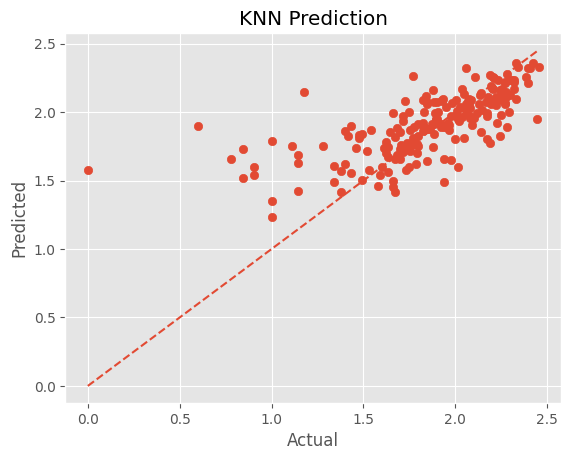

In [ ]:
#Task 3
import matplotlib.pyplot as plt

knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

plt.scatter(y_test, y_pred_knn)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         '--')

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("KNN Prediction")
plt.show()


<details>
<summary> Task hint </summary>
You can perform cross-validation following the same procedure as the random forest model in the main notebook.
</details>

<div style="background-color: #d4edda; border-left: 6px solid #ccc; margin: 20px; padding: 15px; border-radius: 5px;">
    <strong>📓 Submission:</strong> When your notebook is complete in Google Colab, go to <em>File > Download</em> and choose <code>.ipynb</code>. The completed file should be uploaded to Blackboard under assignments for MATE70026.
</div>

## 🌊 Dive deeper

* _Level 1:_ Tackle Chapter 14 on Tree-Based Learners in [Machine Learning Refined](https://github.com/jermwatt/machine_learning_refined#what-is-new-in-the-second-edition).

* _Level 2:_ Explore the XGBoost [tutorials](https://xgboost.readthedocs.io/en/stable/tutorials/model.html), e.g. predicting multiple properties with multi-output regression.

* _Level 3:_ Find the best model (subject to time constraints) with [Automatminer](https://hackingmaterials.lbl.gov/automatminer) based on [TPOT](https://epistasislab.github.io/tpot).